## Курсовой проект "Библиотеки Phyton для Data Science" 

Задание: 
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Целевая переменная: Price

### Импорт пакетов

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse, accuracy_score

from scipy import stats
from scipy.stats import norm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [3]:
matplotlib.rcParams.update({'font.size': 12})

Изменение типа столбцов в dataframe


In [4]:
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)

создание столбца с типом int из категориальных столбцов с двумя значениями boolean

In [5]:
def AB_to_NewIntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df[i+'_'] = df[i+'_'].astype(int)

изменение типа (на int) у категориальных столбцов с двумя значениями

In [6]:
def AB_to_IntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df_[i+'_'] = df_[i+'_'].astype(int)
        df_[i] = df_[i+'_']

Сравнение предсказания и реальных значений

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

Функции для обработки пропусков

In [8]:
def get_NaN_info(df_):
    return len(df_)-df_.count()

def set_NaN_median(df_, col1):
    df_.loc[df_[col1].isnull(), col1] = df_[col1].median()

In [9]:
def features_Stand(features_,X_):
    scaler = StandardScaler()
    X_train_scaled = X_.copy()
    X_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return X_train_scaled

Обработка выбросов

In [10]:
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result

In [11]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [12]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


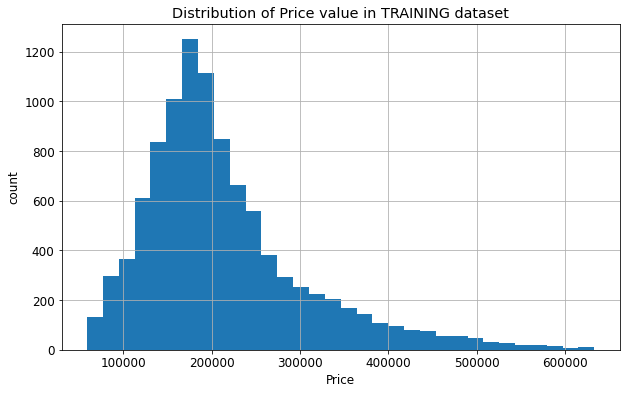

In [18]:
plt.figure(figsize = (10, 6))

train['Price'].hist(bins=32)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price value in TRAINING dataset')
plt.show()

In [19]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [20]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
test['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

Обработка пропусков и приведение типов

In [22]:
to_Str(train,['Id'])
to_Str(test,['Id'])

пропуски NaN 

In [23]:
set_NaN_median(test,'LifeSquare')
set_NaN_median(test,'Healthcare_1')

In [24]:
set_NaN_median(train,'LifeSquare')
set_NaN_median(train,'Healthcare_1')

Площадь кухни

In [25]:
KSmode = train['KitchenSquare'].mode()[0]
LSmode = train['LifeSquare'].mode()[0]
Rmode = train['Rooms'].mode()[0]
print('MODE values in train are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

train.loc[train['Rooms']==0, 'Rooms'] = Rmode
train.loc[train['KitchenSquare']==0, 'KitchenSquare'] = KSmode

MODE values in train are:
KitchenSquare: 1.0 LifeSquare: 32.781260192155735 Rooms: 2.0


In [26]:
train['Rooms'].value_counts()

2.0     3888
1.0     3705
3.0     2235
4.0      150
5.0       18
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Комнаты

In [27]:
KSmode = test['KitchenSquare'].mode()[0]
LSmode = test['LifeSquare'].mode()[0]
Rmode = test['Rooms'].mode()[0]
print('MODE values in test are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

test.loc[test['Rooms']==0, 'Rooms'] = Rmode
test.loc[test['KitchenSquare']==0, 'KitchenSquare'] = KSmode

MODE values in test are:
KitchenSquare: 1.0 LifeSquare: 32.92508663208161 Rooms: 2.0


In [28]:
test['Rooms'].value_counts()

2.0     2032
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

Местоположение

In [29]:
AB_to_IntColumns(test,['Ecology_2','Ecology_3','Shops_2'],'A')
AB_to_IntColumns(train,['Ecology_2','Ecology_3','Shops_2'],'A')

test['Shops_2'].value_counts()

0    4588
1     412
Name: Shops_2, dtype: int64

In [30]:
train = train.drop(['Ecology_2_'],axis=1)
train = train.drop(['Ecology_3_'],axis=1)
train = train.drop(['Shops_2_'],axis=1)
test = test.drop(['Ecology_2_'],axis=1)
test = test.drop(['Ecology_3_'],axis=1)
test = test.drop(['Shops_2_'],axis=1)

test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.910800,56.449500,35.485549,6.043800,8.632000,12.601000,1984.392600,0.119874,0.009600,0.029800,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.082400
std,44.179466,0.837725,19.092787,15.915345,9.912837,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,0.000000,1.000000,1.378543,0.333490,1.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,0.000000,0.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000
75%,77.000000,2.000000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,0.000000,0.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


Работа с выбросами

Интерквартильный размах

In [34]:
def IQ_processing(df, lists):
    for i in lists:
        c = i
        IQP = IQ_param_get(df,c)
        print(c,IQP)
        df[(df[c] < IQP['low_border']) | (df[c]> IQP['high_border'])]
        df.loc[df[c] > IQP['high_border'], c] = IQP['median']
        df.loc[df[c] < IQP['low_border'], c] = IQP['median']
        print('count after procesing:',df[(df[c] < IQP['low_border']) | (df[c]> IQP['high_border'])][c].count())

In [35]:
list = ['LifeSquare','Square', 'KitchenSquare']
list = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 'Social_1', 'Social_2', 'Helthcare_2'] 
list = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
print('processing dataframe train')
IQ_processing(train, list)
print('processing dataframe test')
IQ_processing(test, list)

processing dataframe train
Square {'IQ': 24.125744426186976, 'low_border': 5.586264180189367, 'high_border': 102.08924188493728, 'count': 242, 'median': 52.51330992401352}
count after procesing: 0
LifeSquare {'IQ': 15.899834993080141, 'low_border': 1.6776461714428557, 'high_border': 65.27698614376342, 'count': 517, 'median': 32.781260192155735}
count after procesing: 0
KitchenSquare {'IQ': 8.0, 'low_border': -11.0, 'high_border': 21.0, 'count': 47, 'median': 6.0}
count after procesing: 0
Floor {'IQ': 8.0, 'low_border': -8.0, 'high_border': 24.0, 'count': 66, 'median': 7.0}
count after procesing: 0
HouseFloor {'IQ': 8.0, 'low_border': -3.0, 'high_border': 29.0, 'count': 49, 'median': 13.0}
count after procesing: 0
HouseYear {'IQ': 27.0, 'low_border': 1933.5, 'high_border': 2041.5, 'count': 38, 'median': 1977.0}
count after procesing: 0
Ecology_1 {'IQ': 0.17813400000000001, 'low_border': -0.24955394700000003, 'high_border': 0.46298205300000006, 'count': 61, 'median': 0.07542368}
count af

LifeSquare > Square


In [36]:
train.loc[train['LifeSquare']>train['Square'], 'LifeSquare'] = train['Square'] - train['KitchenSquare']
train[train['LifeSquare']>train['Square']]

test.loc[test['LifeSquare']>test['Square'], 'LifeSquare'] = test['Square'] - test['KitchenSquare']
test[test['LifeSquare']>test['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


Год постройки


In [37]:
mode = train['HouseYear'].mode()[0]
print('mode', mode)
train.loc[train['HouseYear'] > 2019, 'HouseYear'] = mode
train['HouseYear'] = train['HouseYear'].astype(int)
train['HouseYear'].nlargest()

mode 1977


29     2019
142    2019
151    2019
165    2019
190    2019
Name: HouseYear, dtype: int32

In [38]:
test.loc[test['HouseYear'] > 2019, 'HouseYear'] = test['HouseYear'].mode()[0]
test['HouseYear'] = test['HouseYear'].astype(int)
test['HouseYear'].nlargest()

169    2019
212    2019
316    2019
392    2019
525    2019
Name: HouseYear, dtype: int32

In [39]:
def draw_feature(fname):
    t = fname
    plt.figure(figsize = (12, 6))

    train[t].hist(bins=16)
    test[t].hist(bins=16)
    plt.ylabel('count')
    plt.xlabel(t)

    plt.title('Distribution of '+ t +' value in TRAINING and TEST dataset')
    plt.show()

KitchenSquare

In [40]:
m=train['KitchenSquare'].mean()
print('KitchenSquare mean value in TRAIN is:',m)
train.loc[train['KitchenSquare'] < 4, 'KitchenSquare'] = m

m=test['KitchenSquare'].mean()
print('KitchenSquare mean value in TEST is:',m)
test.loc[test['KitchenSquare'] < 4, 'KitchenSquare'] = m


KitchenSquare mean value in TRAIN is: 5.7469
KitchenSquare mean value in TEST is: 5.761


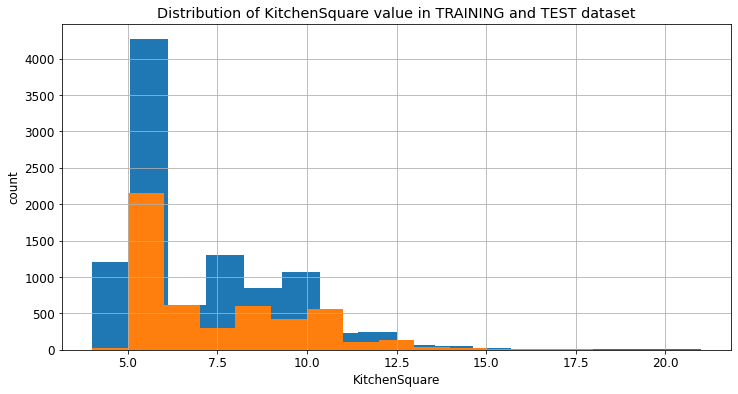

In [41]:
draw_feature('KitchenSquare')

LifeSquare

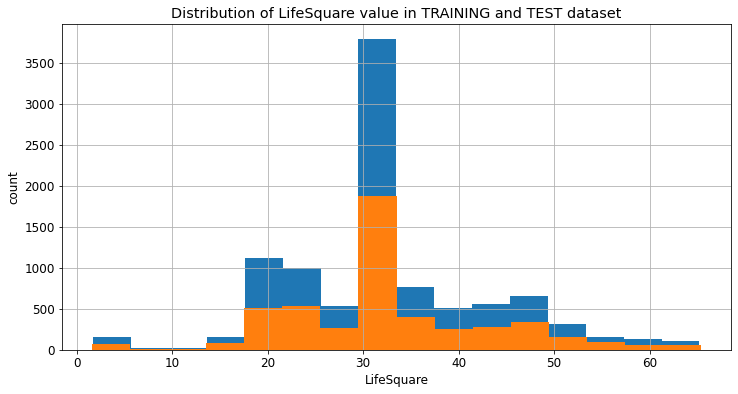

In [42]:
draw_feature('LifeSquare')

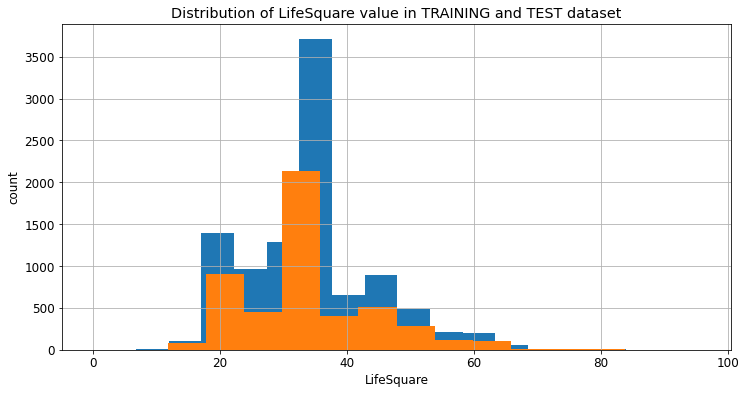

In [43]:
train.loc[train['LifeSquare'] < 15, 'LifeSquare'] = train['Square'] - train['KitchenSquare']
test.loc[test['LifeSquare'] < 15, 'LifeSquare'] = test['Square'] - test['KitchenSquare']

draw_feature('LifeSquare')

Floor & HouseFloor

In [46]:
def HouseFloor_processing(df):
    Fmode = df['Floor'].mode()[0]
    HFmode = df['HouseFloor'].mode()[0]
    print('Floor:',Fmode,'HouseFloor:',HFmode)

    df.loc[(df['HouseFloor']==0) & (HFmode >= df['Floor']),'HouseFloor'] = HFmode 
    df.loc[(df['HouseFloor']==0) & (HFmode < df['Floor']),'HouseFloor'] = df['Floor']

    df.loc[(df['HouseFloor'] < df['Floor'])&(HFmode >= df['Floor']), 'HouseFloor'] = HFmode
    df.loc[(df['HouseFloor'] < df['Floor'])&(HFmode < df['Floor']), 'HouseFloor'] = df['Floor']

In [47]:
print('Processing HouseFloor in TRAIN')
HouseFloor_processing(train)
print('Processing HouseFloor in TEST')
HouseFloor_processing(test)

Processing HouseFloor in TRAIN
Floor: 4 HouseFloor: 17.0
Processing HouseFloor in TEST
Floor: 4 HouseFloor: 17.0


In [48]:
train[train['HouseFloor'] < train['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [49]:
df = train
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.892100,54.654781,33.702655,7.253038,8.398500,14.545200,1984.970900,0.116213,0.009700,0.027500,24.687000,5109.312600,2.378400,904.909000,1.270000,3.343800,0.082500,214138.857399
std,43.587592,0.837811,15.859586,10.231962,2.214583,5.029714,5.200814,17.989064,0.115070,0.098015,0.163543,17.532614,3560.474465,2.652078,70.412835,1.418627,3.083172,0.275139,92872.293865
min,0.000000,1.000000,13.784865,6.784865,4.000000,1.000000,1.000000,1934.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,620.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.794392,27.596772,5.746900,4.000000,10.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,900.000000,0.000000,1.000000,0.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,17.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192269.644879
75%,75.000000,2.000000,64.682943,37.939703,9.000000,12.000000,17.000000,2001.000000,0.194489,0.000000,0.000000,36.000000,7065.000000,4.000000,900.000000,2.000000,5.000000,0.000000,249135.462171
max,209.000000,19.000000,102.056968,89.141693,21.000000,24.000000,29.000000,2019.000000,0.460556,1.000000,1.000000,74.000000,14892.000000,11.000000,1183.000000,5.000000,11.000000,1.000000,633233.466570


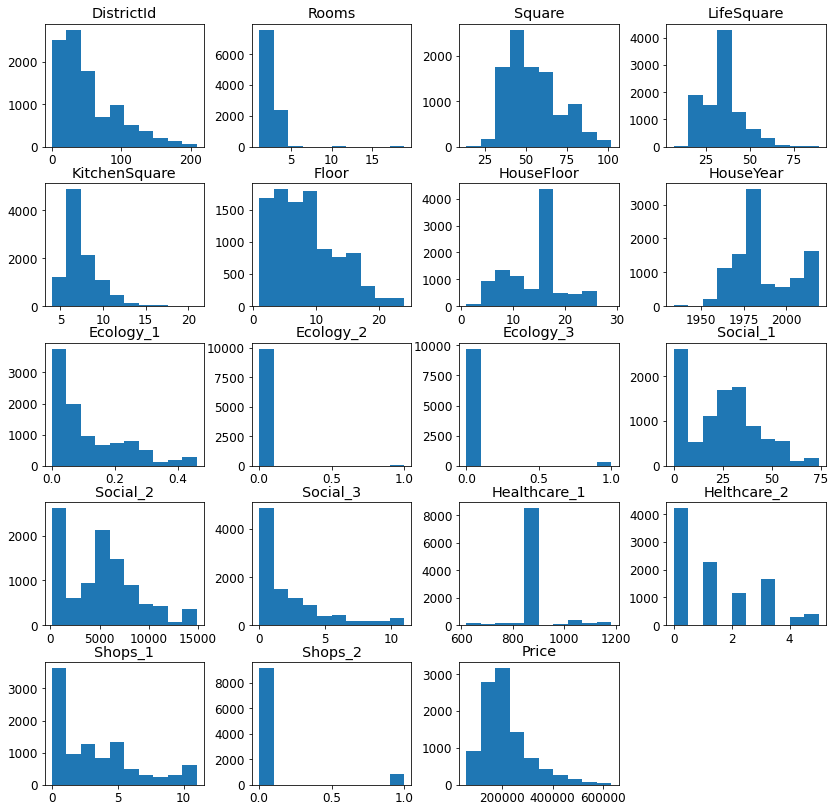

In [50]:
df_num_features = df.select_dtypes(include=['float64', 'int'])
df_num_features.hist(figsize=(14,14), bins=10, grid=False);

### Подготовка данных и стандартизация

In [51]:
feature_names = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Shops_2']

feature_names_without_id = feature_names.copy()
feature_names_without_id.remove('Id')
Xtrain = train[feature_names]
Xtest = test[feature_names]

In [52]:
feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
X2train = features_Stand(feature_names_for_stand, Xtrain)
X2train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,-2.877920e-16,-1.012079e-16,-1.486145e-16,-2.527756e-16,1.442513e-16,-2.043921e-17,7.023271e-16,-2.019007e-15,-9.291040e-17,0.009700,0.027500,4.351408e-16,4.440892e-20,5.747958e-16,1.265132e-15,1.930323e-15,2.151612e-17,0.082500
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.098015,0.163543,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.275139
min,-1.156369e+00,-1.064851e+00,-2.577114e+00,-2.630887e+00,-1.468991e+00,-1.471032e+00,-2.604569e+00,-2.833580e+00,-1.009981e+00,0.000000,0.000000,-1.408132e+00,-1.387894e+00,-8.968511e-01,-4.046467e+00,-8.952769e-01,-1.084587e+00,0.000000
25%,-6.974994e-01,-1.064851e+00,-8.109311e-01,-5.967760e-01,-6.801343e-01,-8.745467e-01,-8.739839e-01,-6.098955e-01,-8.566143e-01,0.000000,0.000000,-1.065895e+00,-9.957914e-01,-8.968511e-01,-6.972089e-02,-8.952769e-01,-7.602290e-01,0.000000
50%,-3.304041e-01,1.287944e-01,-1.350337e-01,-9.005519e-02,-5.658407e-01,-2.780615e-01,4.720267e-01,-4.431191e-01,-3.544886e-01,0.000000,0.000000,1.785334e-02,4.934628e-02,-1.426877e-01,-6.972089e-02,-1.903344e-01,-1.115141e-01,0.000000
75%,5.643907e-01,1.287944e-01,6.323409e-01,4.141199e-01,7.888842e-01,7.160804e-01,4.720267e-01,8.910915e-01,6.802878e-01,0.000000,0.000000,6.452869e-01,5.493047e-01,6.114757e-01,-6.972089e-02,5.146080e-01,5.372008e-01,0.000000
max,3.638814e+00,2.042077e+01,2.989016e+00,5.418493e+00,6.207784e+00,3.102021e+00,2.779473e+00,1.891749e+00,2.992627e+00,1.000000,1.000000,2.812784e+00,2.747717e+00,3.251048e+00,3.949634e+00,2.629435e+00,2.483346e+00,1.000000


In [53]:
X2test = features_Stand(feature_names_for_stand, Xtest)
X2test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,-0.164781,-1.087339,-1.131753,-1.432670,-1.026033,-0.676266,-1.013583,-0.822827,-0.697511,0,0,-0.053267,-0.218758,-0.903859,1.411873,-0.197378,-0.764090,0
1,5925,0.242689,-1.087339,-0.781589,-0.141212,1.281588,-0.280858,0.485412,1.812678,-0.380726,0,0,-1.308227,-1.265773,-0.537301,0.139275,-0.901293,-1.084195,1
2,960,-0.549613,0.106489,0.270825,-0.099655,0.820064,2.091587,0.860161,-0.430305,0.843360,0,0,-0.908921,-0.913044,-0.903859,0.139275,-0.901293,-0.764090,0
3,3848,-0.640162,1.300318,-0.338036,-0.006288,-0.564509,-1.269377,-2.325204,-1.103200,-0.891345,0,0,-1.308227,-1.308782,-0.903859,0.139275,-0.901293,-1.084195,0
4,746,0.514336,-1.087339,-0.078121,-0.099655,-0.674813,-0.083154,0.485412,-0.430305,1.705559,0,0,0.574212,0.713195,0.562373,0.981436,-0.901293,0.836434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,-0.504339,0.106489,-0.739193,-0.348809,-1.026033,-0.478562,0.485412,-1.271424,-0.402679,0,0,0.346038,0.267466,0.562373,0.139275,-0.197378,-0.443985,0
4996,16138,-0.300604,1.300318,2.393940,-0.099655,1.281588,2.486995,2.359156,1.868753,-0.480983,0,0,-0.566660,-0.663090,-0.170743,0.139275,-0.901293,1.156539,0
4997,3912,1.125540,-1.087339,-1.329644,-1.441433,-1.026033,-1.269377,-1.763081,-1.047126,-0.674912,0,0,0.174907,0.383088,-0.537301,1.215369,0.506538,0.516329,0
4998,5722,-0.934446,-1.087339,-1.020897,-1.251276,0.820064,-0.083154,-0.076711,-0.822827,-0.232316,0,0,0.460125,0.786086,0.928931,0.139275,-0.901293,2.436958,0


In [54]:
y = train['Price']

# X - нестандартизированныее, X2 - стандартизированные

X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.3, random_state=42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     7000 non-null   float64
 1   Rooms          7000 non-null   float64
 2   Square         7000 non-null   float64
 3   LifeSquare     7000 non-null   float64
 4   KitchenSquare  7000 non-null   float64
 5   Floor          7000 non-null   float64
 6   HouseFloor     7000 non-null   float64
 7   HouseYear      7000 non-null   float64
 8   Ecology_1      7000 non-null   float64
 9   Ecology_2      7000 non-null   int32  
 10  Ecology_3      7000 non-null   int32  
 11  Social_1       7000 non-null   float64
 12  Social_2       7000 non-null   float64
 13  Social_3       7000 non-null   float64
 14  Healthcare_1   7000 non-null   float64
 15  Helthcare_2    7000 non-null   float64
 16  Shops_1        7000 non-null   float64
 17  Shops_2        7000 non-null   int32  
dtypes: fl

### Модель Liner Regression

In [55]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
y_train

9069    251801.837999
2603    134975.006573
7738    153924.162352
1579    313853.958464
5058    113608.081406
            ...      
5734    216640.538858
5191    241324.507250
5390    163496.966243
860     128710.472293
7270    109129.982392
Name: Price, Length: 7000, dtype: float64

R2:	0.537
MSE:	3872276456.258


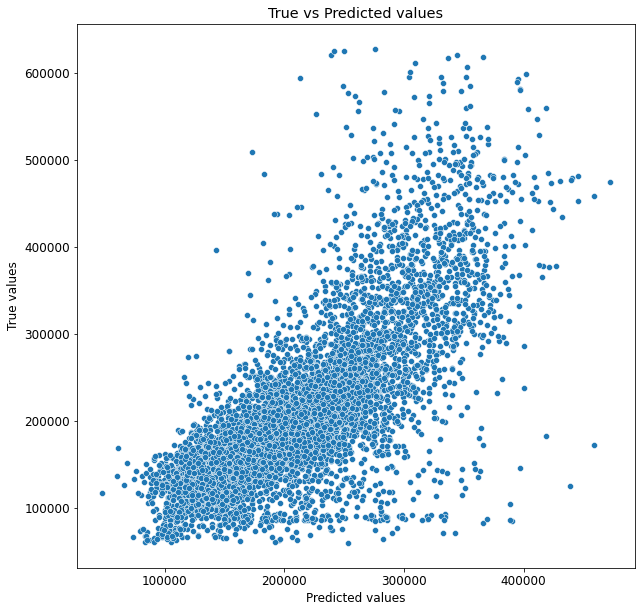

In [57]:
y_train_preds = lr.predict(X_train)
y_train_preds
evaluate_preds(y_train, y_train_preds)

In [58]:
y_valid_preds = lr.predict(X_valid)
y_valid_preds

array([331583.21910946, 214510.8351969 , 233704.75524536, ...,
       218556.31955873, 259281.71699651, 210612.14144338])

In [59]:
check_valid = pd.DataFrame({
    "y_valid": y_valid,
    "y_valid_preds": y_valid_preds.flatten(),
})
check_valid["error"] = check_valid["y_valid_preds"] - check_valid["y_valid"]
check_valid

,y_valid,y_valid_preds,error
6252,225202.099645,331583.219109,106381.119465
4684,361744.269547,214510.835197,-147233.434350
1731,275055.182201,233704.755245,-41350.426955
4742,198133.702204,172584.671287,-25549.030918
4521,221299.460377,153008.544122,-68290.916255
...,...,...,...
8014,231115.381062,251188.225938,20072.844876
1074,150822.681564,181703.214137,30880.532572
3063,196519.976169,218556.319559,22036.343389
6487,380765.543594,259281.716997,-121483.826597


R2:	0.515
MSE:	4466059539.257


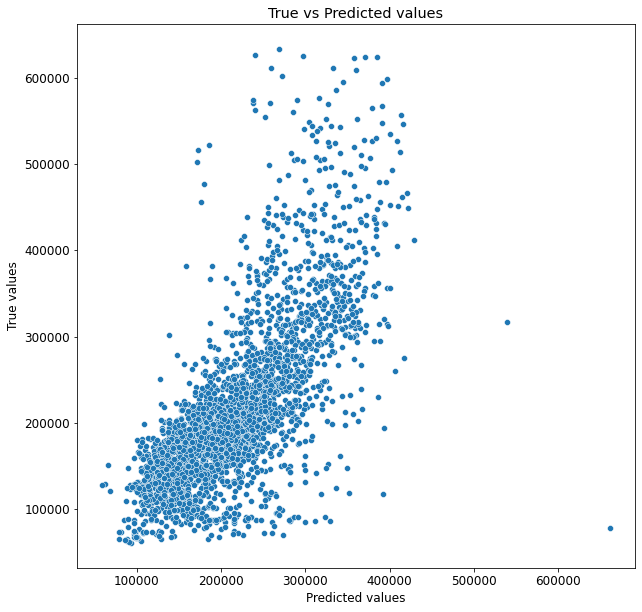

In [60]:
evaluate_preds(y_valid, y_valid_preds)

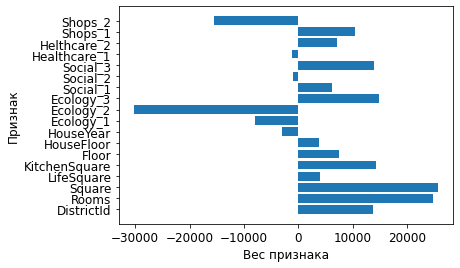

In [61]:
plt.barh(feature_names_without_id, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

Тест:рассчет предсказания

In [62]:
y_test_preds = lr.predict(X2test.drop(['Id'], axis=1))
y_test_preds

array([112040.46557443, 138695.12437723, 210030.59042264, ...,
       142301.75717027, 192716.61221356, 282095.4308323 ])

In [63]:
X2test["Price"] = lr.predict(X2test.drop(['Id'], axis=1))

In [72]:
def SAVE_TO_FILE(df_, modelName):
    df_.loc[:, ['Id', 'Price']].to_csv('osipovaa_predictions(' + modelName + ').csv', index=False)

In [73]:
SAVE_TO_FILE(X2test,'lr')

### Модель Random Forest 

In [66]:
rs = 22
X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.10, random_state=rs)

In [67]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=18, random_state=rs, max_features=7)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features=7, n_estimators=1000,
                      random_state=22)

R2:	0.952
MSE:	412531855.14


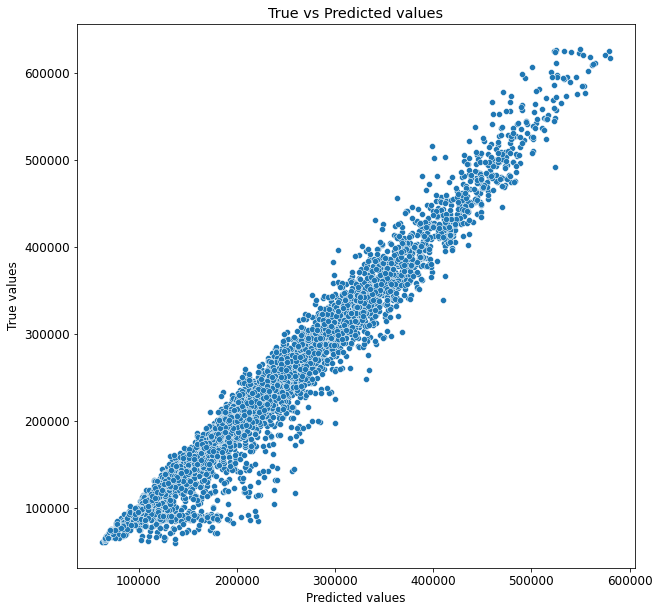

array([249360.56444691, 158200.25745756, 260500.29587606, ...,
       185289.25197451, 226247.55214685, 214399.23993383])

In [68]:
y_train_preds = rf.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_train_preds

R2:	0.719
MSE:	2456666499.589


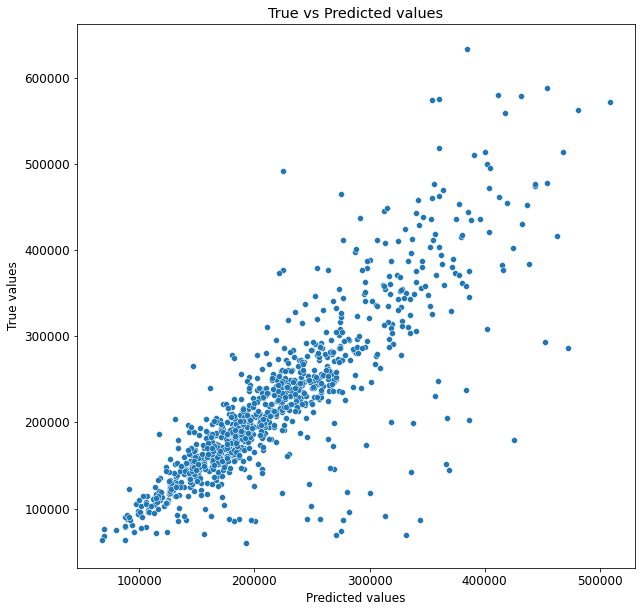

In [69]:
y_valid_preds = rf.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [70]:
df = X2test.drop(['Price'],axis=1).drop(['Id'],axis=1)
X2test['Price'] = rf.predict(df)

In [74]:
SAVE_TO_FILE(X2test,'rf')